
<center>1 Reflectivity, Attenuation, and Differential Reflectivity at S- vs C-Band
=========================
<center>
<i>Steve Nesbitt<sup>1</sup>, Paola Salio<sup>2,3</sup>, Luciano Vidal<sup>3</sup>
<br>
<sup>1</sup>University of Illinois at Urbana-Champaign<br>
<sup>2</sup>CIMA-CONICET-UBA / DCAO UBA-FCEN<br>
<sup>3</sup>Servicio Meteorólogical Nacional, Argentina</i>
</center>

This exercise will cover the basics of using the Python ARM Radar Toolkit (Py-ART) radar object for plotting your first data. We will introduce some basic plotting concepts and examine some C- and S-Band data from the NASA/DOE Midlatitude Continental Convective Clouds Experiment (MC3E) that took place from April 22 – June 6, 2011, near Lamont, Oklahoma, USA.

## Let's get the data for this exercise - make sure you have the data from exercise 0

In [12]:
%%script bash
mkdir ../data
wget -nc -P ../data https://www.atmos.illinois.edu/~snesbitt/data/cfrad.20110523_222145.000_to_20110523_223049.000_npol1_v1_PPI.nc
wget -nc -P ../data https://www.atmos.illinois.edu/~snesbitt/data/cfrad.20110523_222238.000_to_20110523_222256.000_ARM__v0_s00_az189.00_RHI.nc

mkdir: cannot create directory `../data': File exists
File `../data/cfrad.20110523_222145.000_to_20110523_223049.000_npol1_v1_PPI.nc' already there; not retrieving.

File `../data/cfrad.20110523_222238.000_to_20110523_222256.000_ARM__v0_s00_az189.00_RHI.nc' already there; not retrieving.



## Get started

Let's first set up our C-Band data:

In [7]:
import pyart
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
filename = '../data/cfrad.20110523_221616.000_to_20110523_222150.1000_sgpc_v0_SUR.nc'

In [8]:
radar = pyart.io.read(filename)

To save memory, we will subset the data for only the first two PPI sweeps.

In [3]:
radar = radar.extract_sweeps([0, 1])

Now, let's load in the S-Band data into a different structure.

In [4]:
filename2 = '../data/cfrad.20110523_222145.000_to_20110523_223049.000_npol1_v1_PPI.nc'
radar2 = pyart.io.read(filename2)
radar2 = radar2.extract_sweeps([0, 1])

FileNotFoundError: [Errno 2] No such file or directory: '../data/cfrad.20110523_222145.000_to_20110523_223049.000_npol1_v1_PPI.nc'

What do we have?

In [5]:
print radar.fields.keys()

[u'corrected_reflectivity_horizontal', u'reflectivity_horizontal', u'rain_rate_A', u'specific_attenuation', u'unf_dp_phase_shift', u'mean_doppler_velocity', u'diff_phase', u'dp_phase_shift', u'recalculated_diff_phase', u'norm_coherent_power', u'corrected_mean_doppler_velocity', u'doppler_spectral_width', u'diff_reflectivity', u'proc_dp_phase_shift', u'copol_coeff']


In [6]:
print radar2.fields.keys()

[u'KD', u'DR', u'SQ', u'SW', u'CZ', u'VR', u'DZ', u'ZT', u'PH', u'RH', u'SD']


First, let's just make a basic PPI plot!

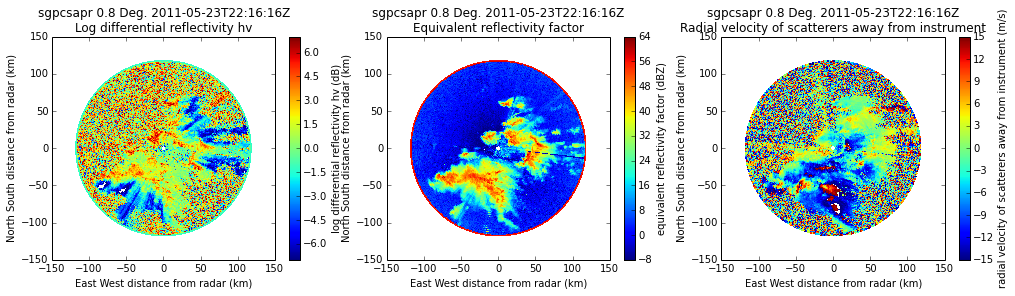

In [7]:
#create an instance of the class using our radar
display = pyart.graph.RadarMapDisplay(radar)
#create a Matplotlib figure
f = plt.figure(figsize = [17,4])


#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
plt.subplot(1, 3, 1) 
display.plot_ppi('diff_reflectivity',vmin = -7, vmax = 7)
plt.subplot(1, 3, 2) 
display.plot_ppi('reflectivity_horizontal', vmin = -8, vmax = 64)
plt.subplot(1, 3, 3) 
display.plot_ppi('mean_doppler_velocity', vmin = -15, vmax = 15)



Ok! We are going to use Py-ART's RadarMapDisplay class to visualize this PPI on a map . This class is well documented and available here: <a href = 'http://arm-doe.github.io/pyart/dev/user_reference/generated/pyart.graph.RadarMapDisplay.html#pyart.graph.RadarMapDisplay'>Click!</a>

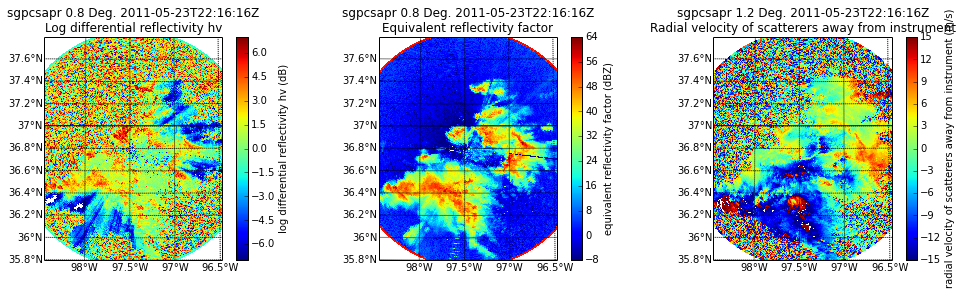

In [8]:
#create an instance of the class using our radar
display = pyart.graph.RadarMapDisplay(radar)
#create a Matplotlib figure
f = plt.figure(figsize = [17,4])
minlon=radar.longitude['data']-1.
maxlon=radar.longitude['data']+1.
minlat=radar.latitude['data']-1.
maxlat=radar.latitude['data']+1.


#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
plt.subplot(1, 3, 1) 
display.plot_ppi_map('diff_reflectivity', max_lat = maxlat, min_lat =minlat, min_lon = minlon, max_lon = maxlon,
                     vmin = -7, vmax = 7, lat_lines = np.arange(30,40,.2), lon_lines = np.arange(-100,-90, .5),
                     resolution = 'i')
plt.subplot(1, 3, 2) 
display.plot_ppi_map('reflectivity_horizontal', max_lat = maxlat, min_lat =minlat, min_lon = minlon, max_lon = maxlon,
                     vmin = -8, vmax = 64, lat_lines = np.arange(30,40,.2), lon_lines = np.arange(-100, -90, .5),
                     resolution = 'i')
plt.subplot(1, 3, 3) 
display.plot_ppi_map('mean_doppler_velocity', sweep = 1, max_lat = maxlat, min_lat =minlat, min_lon = minlon, max_lon = maxlon,
                     vmin = -15, vmax = 15, lat_lines = np.arange(30,40,.2), lon_lines = np.arange(-100, -90, .5),
                     resolution = 'i')

 

We can smooth the fields to make them look a bit better if we wish.  Here is an example of using one of the Py-ART internal tools to smooth the data, and duplicate a field within the radar structure.  We will use numpy's built in smoothing to mask $Z_{dr} | \rho_{hv} < 0.7$

In [9]:
# First we create an independant copy of one of our radar fields.. we need to make sure changes made do not 
# infer back onto the object it was copied from (common cause of issues in Python)

smooth_zdr = radar.fields['diff_reflectivity']['data'].copy()

# Now for each of the radials in the volume we want to do an 8-point smooth by convolving the data with a Hanning window..
# rather than write out the code here we are going to use Py-ART's smooth and trim function which also makes sure
# the returned array has the same size as the original array.. 
# Check here: https://github.com/ARM-DOE/pyart/blob/master/pyart/correct/phase_proc.py#L242

for i in range(smooth_zdr.shape[0]):
    smooth_zdr[i,:] = pyart.correct.phase_proc.smooth_and_trim(smooth_zdr[i,:], 8)

#Let's mask the data where rho_hv < 0.7
    
smooth_zdr = np.ma.masked_where(radar.fields['copol_coeff']['data'] < 0.7,smooth_zdr)

# Now that we have add this data as a new field, using the same metadata as the 
# differential_reflectivity field.

radar.add_field_like('diff_reflectivity', 'diff_reflectivity_smooth',  smooth_zdr)

Ok, let's plot and zoom in a bit.

(-75, 75)

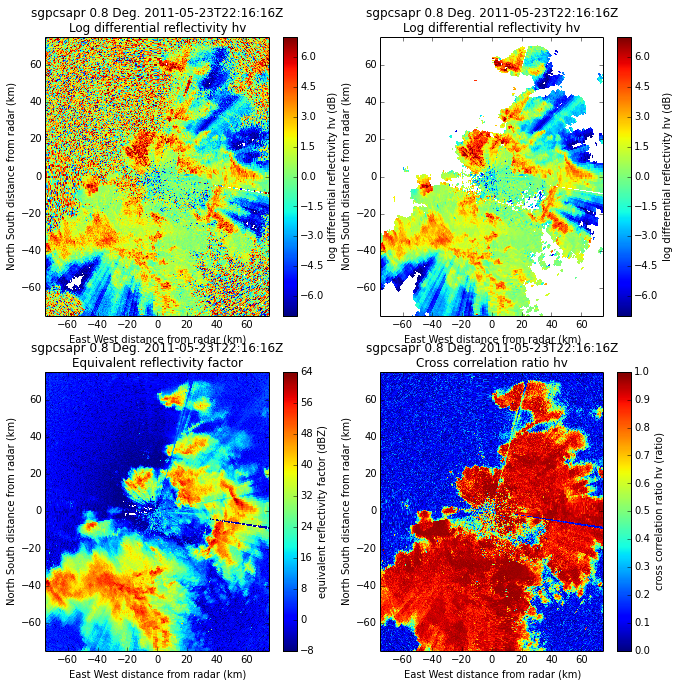

In [10]:
#create an instance of the class using our radar
display = pyart.graph.RadarMapDisplay(radar)
#create a Matplotlib figure
f = plt.figure(figsize = [11,11])
minlon=radar.longitude['data']-1.
maxlon=radar.longitude['data']+1.
minlat=radar.latitude['data']-1.
maxlat=radar.latitude['data']+1.


#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
plt.subplot(2, 2, 1) 
display.plot_ppi('diff_reflectivity', vmin = -7, vmax = 7)
plt.xlim(-75,75)
plt.ylim(-75,75)

plt.subplot(2, 2, 2) 
display.plot_ppi('diff_reflectivity_smooth', vmin = -7, vmax = 7)
plt.xlim(-75,75)
plt.ylim(-75,75)

plt.subplot(2, 2, 3) 
display.plot_ppi('reflectivity_horizontal', vmin = -8, vmax = 64)
plt.xlim(-75,75)
plt.ylim(-75,75)

plt.subplot(2, 2, 4) 
display.plot_ppi('copol_coeff', vmin = 0, vmax = 1)
plt.xlim(-75,75)
plt.ylim(-75,75)




Let's clean up the NPOL $Z_{dr}$ in dictionary radar2

In [23]:
# First we create an independant copy of one of our radar fields.. we need to make sure changes made do not 
# infer back onto the object it was copied from (common cause of issues in Python)

smooth_zdr = radar2.fields['DR']['data'].copy()

# Now for each of the radials in the volume we want to do an 8-point smooth by convolving the data with a Hanning window..
# rather than write out the code here we are going to use Py-ART's smooth and trim function which also makes sure
# the returned array has the same size as the original array.. 
# Check here: https://github.com/ARM-DOE/pyart/blob/master/pyart/correct/phase_proc.py#L242

for i in range(smooth_zdr.shape[0]):
    smooth_zdr[i,:] = pyart.correct.phase_proc.smooth_and_trim(smooth_zdr[i,:], 8)

#Let's mask the data where rho_hv < 0.7
    
smooth_zdr = np.ma.masked_where(radar2.fields['RH']['data'] < 0.7,smooth_zdr)

# Now that we have add this data as a new field, using the same metadata as the 
# differential_reflectivity field.

radar2.add_field_like('DR', 'DR_smooth',  smooth_zdr)

Now, let's zoom in (using user-defined limits) and plot both radars on the same map.

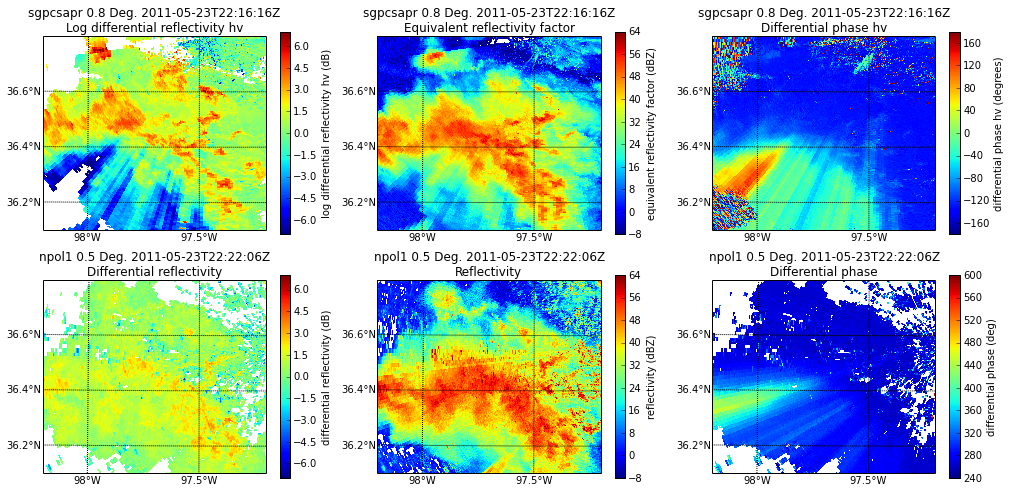

In [24]:
#create an instance of the class using our radar
#create a Matplotlib figure
f = plt.figure(figsize = [17,8])



minlon=-98.2
maxlon=-97.2
minlat=36.1
maxlat=36.8

display = pyart.graph.RadarMapDisplay(radar)



#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
plt.subplot(2, 3, 1) 
display.plot_ppi_map('diff_reflectivity_smooth', max_lat = maxlat, min_lat =minlat, min_lon = minlon, max_lon = maxlon,
                     vmin = -7, vmax = 7, lat_lines = np.arange(30,40,.2), lon_lines = np.arange(-100,-90, .5),
                     resolution = 'i')
plt.subplot(2, 3, 2) 
display.plot_ppi_map('reflectivity_horizontal', max_lat = maxlat, min_lat =minlat, min_lon = minlon, max_lon = maxlon,
                     vmin = -8, vmax = 64, lat_lines = np.arange(30,40,.2), lon_lines = np.arange(-100, -90, .5),
                     resolution = 'i')
plt.subplot(2, 3, 3) 
display.plot_ppi_map('dp_phase_shift', sweep = 0, max_lat = maxlat, min_lat =minlat, min_lon = minlon, max_lon = maxlon,
                     vmin = -180, vmax = 180, lat_lines = np.arange(30,40,.2), lon_lines = np.arange(-100, -90, .5),
                     resolution = 'i')

display = pyart.graph.RadarMapDisplay(radar2)


#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
plt.subplot(2, 3, 4) 
display.plot_ppi_map('DR_smooth', max_lat = maxlat, min_lat =minlat, min_lon = minlon, max_lon = maxlon,
                     vmin = -7, vmax = 7, lat_lines = np.arange(30,40,.2), lon_lines = np.arange(-100,-90, .5),
                     resolution = 'i')
plt.subplot(2, 3, 5) 
display.plot_ppi_map('DZ', max_lat = maxlat, min_lat =minlat, min_lon = minlon, max_lon = maxlon,
                     vmin = -8, vmax = 64, lat_lines = np.arange(30,40,.2), lon_lines = np.arange(-100, -90, .5),
                     resolution = 'i')
plt.subplot(2, 3, 6) 
display.plot_ppi_map('PH', sweep = 0, max_lat = maxlat, min_lat =minlat, min_lon = minlon, max_lon = maxlon,
                     vmin = 240, vmax = 600, lat_lines = np.arange(30,40,.2), lon_lines = np.arange(-100, -90, .5),
                     resolution = 'i')

 

Range-height indicator scans are similarly easy.

In [21]:
filename='../data/cfrad.20110523_222238.000_to_20110523_222256.000_ARM__v0_s00_az189.00_RHI.nc'

radar3 = pyart.io.read(filename)
radar3.fields

{'cross_correlation_ratio': {'_FillValue': -9999.0,
  'coordinates': 'time range',
  'data': masked_array(data =
   [[0.9917999505996704 0.6036999225616455 0.5030999183654785 ...,
    0.9914999008178711 0.9914999008178711 0.9912999868392944]
   [0.9917999505996704 0.5758999586105347 0.5532000064849854 ...,
    0.9915999174118042 0.9915999174118042 0.9912999868392944]
   [0.9918999671936035 0.5982999801635742 0.5142999887466431 ...,
    0.9918999671936035 0.9917999505996704 0.9916999340057373]
   ..., 
   [0.9917999505996704 0.6007999181747437 0.4298999309539795 ...,
    0.9917999505996704 0.9917999505996704 0.9914999008178711]
   [0.9840999841690063 0.6959999799728394 0.5299999713897705 ...,
    0.9840999841690063 0.9840999841690063 0.983799934387207]
   [-- -- -- ..., -- -- --]],
               mask =
   [[False False False ..., False False False]
   [False False False ..., False False False]
   [False False False ..., False False False]
   ..., 
   [False False False ..., False False

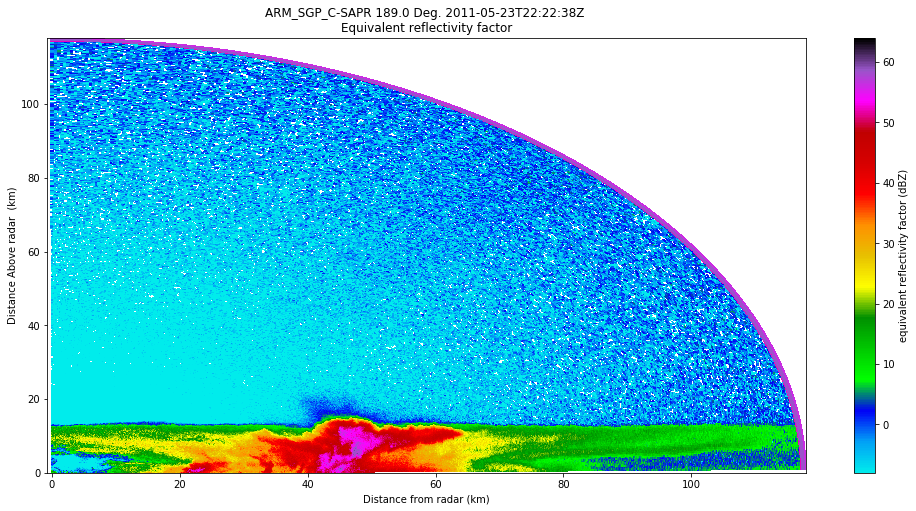

In [34]:
#create an instance of the class using our radar
#create a Matplotlib figure
f = plt.figure(figsize = [17,8])

display3 = pyart.graph.RadarMapDisplay(radar3)

display3.plot_rhi('reflectivity',sweep=0, vmin = -8, vmax = 64, filter_transitions=False)
